 # BEM coupling with plane wave approximation

In [5]:
import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force
from capytaine.bem.solver import BEMSolver
from capytaine.green_functions.delhommeau import Delhommeau
from capytaine.bem.engines import BasicMatrixEngine
from capytaine.bem.problems_and_results import RadiationProblem
from capytaine.bodies.predefined.spheres import Sphere
cpt.__version__ #get_potential_on_mesh if not version 2.0



omega = 1.0
rho = 1000# density of our special material
wave_amp = 1
wave_num =  1.0/9.81


### Some functions that are required down the road for implementation

In [6]:
#%%writefile pwa_utils.py
def generate_body(xyz):
    mesh1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=1, length=2, center=(0, 0, 0))
    body = cpt.FloatingBody(mesh1)
    body.add_translation_dof(name='Heave')
    body = body.immersed_part()
    body.name = f'{xyz[0]}_{xyz[1]}_{xyz[2]}'
    return body




#calculate angle theta_ij from centre of one body to other
def theta_ij(X,Y): 
    x1,y1= X[0],X[1]
    x2,y2 = Y[0], Y[1]
    
    if x1 ==x2 and y1==y2:
        return 0
    if x2==x1:
        theta = np.pi/2
    else:
        theta = np.arctan2((y2-y1),(x2-x1))
    return theta


#step 2
def phi_j_star(phi_ij,theta,X,Y,z,k):
    
    '''phi_ij is the vector of all the effect at that body from all other bodies'''
   # print(f'body 1 is at {X} and body2 is at {Y}')
    x,y = X[0],X[1]
    xj,yj = Y[0],Y[1]
    if x==xj and y==yj:
        return 0
    #multiplier = np.exp((1j*k*(xj-x)*np.cos(theta)) + ((yj-y)*np.sin(theta)))
    #doing some stuff
    #divider = np.exp((1j*k*(xj)*np.cos(theta)) + ((yj)*np.sin(theta)))
    multiplier = np.exp(1j*k*((x-xj)*np.cos(theta) + (y-yj))*np.sin(theta))
  #  print(f'the multiplier for body at {X} and {Y} with angle {theta} is {multiplier}')
    res = phi_ij * multiplier * np.exp(k*z)#kz = 0 #e^kz = 1
    return res

#{(10, 10, 0): {(10, 10, 0): 0,
  #(0, 0, 0): (8.415476709952118-2.9519008598532284j),
  #(5, 5, 0): (8.415476709952118-2.9519008598532284j),
  #(15, 15, 0): (8.415476709952118-2.9519008598532284j)

def get_phistarj_sum(phi_starj,xyzees):
    xyz_phi = {xyz :[] for xyz in xyzees}
    for k,v in phi_starj.items():
        for s,m in v.items():
          #  print(f"thee value of m = {m}")
            xyz_phi[k].append(m)
     #   print("next xyz")
    print(xyz_phi.items())
    xyz_phi = {k:sum(v) for k,v in xyz_phi.items()}
    #print("Afteer summation ")
  
    return xyz_phi



def solve_forces(diff_result):
    
    """
    """
    return diff_result.forces



The method is based upon an idea due to Simon 3
originally devised in connection with the theory of arrays
of wave-power devices. A diverging wave scattered from
one cylinder is replaced by a plane wave of appropriate
amplitude in the neighbourhood of another cylinder. Once
the amplitude and phase of the equivalent plane wave have
been determined, **the problem reduces to summing the
effects of plane waves on any given cylinder**

#### 1. Initialize the bodies and define diffraction and radiation problems and solve

This step is performed in isolation and this is the first BEM run where we evaluate the green's function

#### generating the arrays of the converter as discussed in the paper

Square grid of cylinders with diameter and draft of 10m

In [7]:
resolution = 2
length = 10
radius = 5




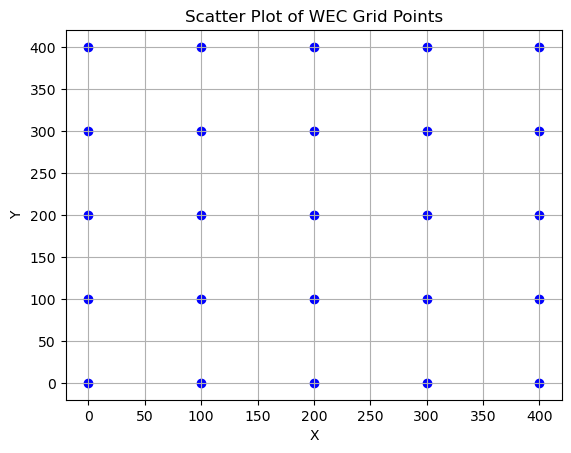

In [8]:
x_coords,y_coords = np.arange(0,500,100),np.arange(0,500,100)
X, Y = np.meshgrid(x_coords, y_coords)
# Flatten the mesh grid coordinates
x_flattened = X.flatten()
y_flattened = Y.flatten()

# Plot the scatter plot
plt.scatter(x_flattened, y_flattened, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of WEC Grid Points')
plt.grid(True)
plt.show()

### Locations of the WECs and mapping out their neighbors

In [9]:
from capytaine import assemble_dataset

xyzees = {(0,0,0),(5,5,0)}
#if using more bodies from above
#xyzees = {(x,y,0) for x,y in zip(x_flattened,y_flattened)}
#print(xyzees)
    
bodies = [generate_body(xyz) for xyz in xyzees ]

#print(get_neighbors(xyzees))


def get_neighbors(xyzees):
    neighbor = {xyz:[] for xyz in xyzees}
    for xyz in xyzees:
        for zyx in xyzees:
            if not xyz == zyx:
                neighbor[xyz].append(zyx)
    return neighbor

neighbors = get_neighbors(xyzees)
cache_engine = BasicMatrixEngine(matrix_cache_size=0)

solver = cpt.BEMSolver(engine=cache_engine)
# if using more bodies
#neighbors = get_neighbors(xyzees)

#### Let's first solve usine BEM Direct way. (Joining the bodies) 
##### Considering an array as a single unit

Note that all body (one body after joining) has same Heave forces. Is that what happens in 
PWA convergence as well? Like, all the bodies in different location have same heave forces.

In [10]:
Jointbodies =cpt.FloatingBody.join_bodies(*bodies)
singleBody = bodies[0]
Jointbodies.name = "joint"
#Jointbodies.show_matplotlib()
diffProblem = cpt.DiffractionProblem(body=Jointbodies, water_depth = np.infty,
                                      omega=omega, wave_direction=0.) 

SinglediffProblem = cpt.DiffractionProblem(body=singleBody, water_depth = np.infty,
                                      omega=omega, wave_direction=0.)
radProblem  = cpt.RadiationProblem(body= Jointbodies, water_depth = np.infty,
                                      omega=omega) 
 
diff_results = solver.solve(diffProblem) 
single_diff_results = solver.solve(SinglediffProblem) 
rad_results = solver.solve(radProblem)
forces_direct_way = diff_results.forces
single_forces = single_diff_results.forces
print(f"single force of one body :{single_forces} and \n in array {forces_direct_way}")


single force of one body :{'Heave': (-1806.5738092592817-258.5293723028756j)} and 
 in array {'0_0_0__Heave': (-3309.7383562105933-109.44907886177624j), '5_5_0__Heave': (-3309.7383562105933-109.44907886177624j)}


### PWA Coupling with BEM method

In [11]:

loc_bodies = {body:xyz for xyz,body in zip(xyzees,bodies)}
loc_to_body = {xyz:body for xyz,body in zip(xyzees,bodies)}
#caching interaction matrices help make things go brrrrrrrr



def get_results(problems):
    results = [solver.solve(pb, keep_details = True) for pb in sorted(problems)]
    return results
 
diff_problems = {body:cpt.DiffractionProblem(body=body, water_depth = np.infty,
                                      omega=omega, wave_direction=0.) for body in bodies}

diff_loc= {generate_body(loc):loc for loc in xyzees }

loc_diff = {loc_bodies.get(body):diff for body,diff in diff_problems.items() }

rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
                                      omega=omega) for body in bodies}

diff_results = {body:solver.solve(problem) for body,problem in diff_problems.items()}
rad_results = {body:solver.solve(problem) for body,problem in rad_problems.items()}


diff_results_first_iter = diff_results
rad_results_first_iter = rad_results
#added_mass = {body:assemble_dataset(result) for body, result in rad_results.items()}



### UPDATE

In [60]:
def update_boundary_condition(DiffProblem,new_boundary_excitation):
    '''Take in the normal velocities not the potential at the other location'''
    #normal_velocities = np.einsum('...k,...k->...', new_boundary_excitation, DiffProblem.body.mesh.faces_normals)
    DiffProblem.boundary_condition  = DiffProblem.boundary_condition + new_boundary_excitation
    print(f"excitation updater: {np.exp(new_boundary_excitation)}")
    return DiffProblem

### 2. Get the Incident potentials, diffraction potentials, radiation potentials for each body at their own location and the location of other bodies


STEPS

1) Assume each body as isolated and solve the diffraction and radiation problem with $usual$ body condition
2) Find the potential of the incident PLANE WAVE.$A_{ij}$ being the apmplitude of body $j$ at body $i$, this can be generated at any other location from capytaine. And according to simon(1982) we can approximate the impact of outgoing waves from a body on all other bodies by an incident plane wave of appropriately chosen amplitude $A_{ij}$.

3) Find the total effect at each body j due to other body i
4) The diffraction potential depends on the boundary condition from the incoming incident plane waves so that has to be updated for new iteration.
5)  Having computed the effect at all the bodies in the array we compute the contribution of all the bodies as isolated (step 1) due to the excitation induced by new φ∗
    1) New excitation means new boundary condition. CALCULATE NEW BOUNDARY CONDITION for each iteration until convergence. Is new boundary condition  = usual boundary condition + new $\phi^*$?
    2) For each body to calculate new diffraction and radiation problem ? Meaning either re-evaluate the influence matrices or store from last time (step 1) if the matrix do not change themselves.
    3) Use the already stored influence matrices (green's function matrix and its normal derivative matrix)
   



#### find the location of neighbors to each floating body

In [61]:
body_neighbors_locs = {body:neighbors.get(loc_bodies.get(body)) for body in bodies}
body_neighbors_locs

{FloatingBody(mesh=cylinder_24, dofs={Heave}, name=0_0_0): [(5, 5, 0)],
 FloatingBody(mesh=cylinder_30, dofs={Heave}, name=5_5_0): [(0, 0, 0)]}

###  Get the potential of a body to other location - Find the potential of incident PLANE WAVE $A_{IJ}$

> Capytaine version 1.5 has the function as `get_potential_on_mesh` while new v2.0 have `compute_potential`

In [62]:
body_potential_at_neighbors = {body:(dict(zip(body_neighbors_locs[body], 
                                     solver.compute_potential(np.array(body_neighbors_locs[body]),
                                                              diff_results[body]))))
                                       for body in bodies}


body_velocity_at_neighbors = {body:(dict(zip(body_neighbors_locs[body], 
                                     solver.compute_velocity(np.array(body_neighbors_locs[body]),
                                                              diff_results[body]))))
                                       for body in bodies}

body_potential_at_neighbors 

{FloatingBody(mesh=cylinder_24, dofs={Heave}, name=0_0_0): {(5,
   5,
   0): (8.482332126973382e-05+0.000134004463130016j)},
 FloatingBody(mesh=cylinder_30, dofs={Heave}, name=5_5_0): {(0,
   0,
   0): (0.000832587057951646+0.0010773170673753223j)}}

In [63]:
# body_potential_at_neighbors = {}

# for body in bodies:
#     neighbor_locs = body_neighbors_locs[body]
#     potentials = solver.compute_velocity(np.array(neighbor_locs), diff_results[body])
#     neighbor_potentials = dict(zip(neighbor_locs, potentials))
#     print(neighbor_potentials)
#     body_potential_at_neighbors[body] = neighbor_potentials
body_potential_at_neighbors

{FloatingBody(mesh=cylinder_24, dofs={Heave}, name=0_0_0): {(5,
   5,
   0): (8.482332126973382e-05+0.000134004463130016j)},
 FloatingBody(mesh=cylinder_30, dofs={Heave}, name=5_5_0): {(0,
   0,
   0): (0.000832587057951646+0.0010773170673753223j)}}

We need new updated diffraction problem as well because the $B_{ij}$ is also changing..

$ \phi^*_j = \displaystyle\sum_{i}^{N}A_{ij} \frac{\phi_0 (x_i,y_i,0;\beta_{ij})}{\phi_0 (x_j,y_j,0;\beta_{ij})} $

In [64]:



body_potential_at_itself = {body:   solver.compute_potential(loc_bodies[body],
                                                              diff_results[body])
                                       for body in bodies}

body_potential_at_itself

{FloatingBody(mesh=cylinder_24, dofs={Heave}, name=0_0_0): array([0.00076873+0.00017863j]),
 FloatingBody(mesh=cylinder_30, dofs={Heave}, name=5_5_0): array([-3.28076924e-05+0.00027163j])}

### $\phi_{ij}$ or  $𝐴_{ij}$ Get the all other potential at each location/body..


This is just re-structuring earlier result so that we have results of all other WECs at each location

In [65]:
# def get_all_other_phi(body_potential_at_neighbors):
all_other_phi_each_loc = {xyz:{loc_bodies.get(d):k.get(xyz,0) for d,k in body_potential_at_neighbors.items()} for xyz in xyzees }

#phi_n normal velocity now
all_other_velo_n_each_loc = {xyz:{loc_bodies.get(d):k.get(xyz,0) for d,k in body_velocity_at_neighbors.items()} for xyz in xyzees }

all_other_phi_each_loc 

{(0, 0, 0): {(0, 0, 0): 0,
  (5, 5, 0): (0.000832587057951646+0.0010773170673753223j)},
 (5, 5, 0): {(0, 0, 0): (8.482332126973382e-05+0.000134004463130016j),
  (5, 5, 0): 0}}

### $\phi_j^*$ get the total effect of each bodies

Like all the body had same exact potential at that location? I don't trust it.

In [66]:
#First fet the thetas

thetas = {k:{s:theta_ij(k,s) for s,m in v.items()} for k,v in all_other_phi_each_loc.items()}
thetas

{(0, 0, 0): {(0, 0, 0): 0, (5, 5, 0): 0.7853981633974483},
 (5, 5, 0): {(0, 0, 0): -2.356194490192345, (5, 5, 0): 0}}

In [67]:
def phi_j_star(phi_ij,theta,X,Y,z,k):
    
    '''phi_ij is the vector of all the effect at that body from all other bodies'''
   # print(f'body 1 is at {X} and body2 is at {Y}')
    x,y = X[0],X[1]
    #print(f"the phi ij is {phi_ij}")
    xj,yj = Y[0],Y[1]
    if x==xj and y==yj:
        return 0
    #multiplier = np.exp((1j*k*(xj-x)*np.cos(theta)) + ((yj-y)*np.sin(theta)))
    #doing some stuff
    #divider = np.exp((1j*k*(xj)*np.cos(theta)) + ((yj)*np.sin(theta)))
    multiplier = np.exp(1j*k*((x-xj)*np.cos(theta) + (y-yj)*np.sin(theta)))
  #  print(f'the multiplier for body at {X} and {Y} with angle {theta} is {multiplier}')
    res = phi_ij * multiplier #kz = 0 #e^kz = 1
    return res


In [68]:
z = 0
phi_starij = {xyz:{nbros:phi_j_star(all_other_phi_each_loc[xyz][nbros],thetas[xyz][nbros],xyz,nbros,z,wave_num) for nbros in neighbors} for xyz in xyzees}
#for velocity now
#phi_starij_velo = {xyz:{nbros:phi_j_star(all_other_velo_n_each_loc[xyz][nbros],thetas[xyz][nbros],xyz,nbros,z,wave_num) for nbros in neighbors} for xyz in xyzees}
phi_starij 

{(0, 0, 0): {(0, 0, 0): 0,
  (5, 5, 0): (0.0013365189288326584+0.0002598661686305971j)},
 (5, 5, 0): {(0, 0, 0): (0.00015216704073204982+4.469209868470038e-05j),
  (5, 5, 0): 0}}

### Get the Total potential on the body surface - 
#### Make sure we add all N but not when i==j so the value should be 0 for same location 

In [69]:

new_excitation = get_phistarj_sum(phi_starij,xyzees)
#new_excitation_velo = get_phistarj_sum(phi_starij_velo,xyzees)

new_excitation

dict_items([((0, 0, 0), [0, (0.0013365189288326584+0.0002598661686305971j)]), ((5, 5, 0), [(0.00015216704073204982+4.469209868470038e-05j), 0])])


{(0, 0, 0): (0.0013365189288326584+0.0002598661686305971j),
 (5, 5, 0): (0.00015216704073204982+4.469209868470038e-05j)}

Having computed this effect at each body in the array we then compute the contribution of all the bodies as isolated ( as in step 1) induced by new excitation

#### Get the all other potential at each location/body with new excitation
If new excitation is the potential and we have this new excitation **at** each location, how do we go from getting the contribution of this $\phi$ to other location?

- New boundary condition !!!!! and solve the diffraction and radiation problems with new boundary condition. 
 - but how does the new excitation give new boundary condition?

- Write a function to get the influence matrices and store them in a dictionary 

- Calculate new `body_potential_at_neighbors` from earlier to loop it back in a while loop. The potential at other location this time is not going to be the airywave potential calculation but just the  calculation function `phi_j_star` but keep new potential at each neigbors in the format `body_potential_at_neighbors` 



### Updated diffraction and radiation problems

1) Normal velocity
$\frac{\partial}{}$

In [70]:
# def get_influence_matrices(prob):
#             S, K = self.engine.build_matrices(
#             problem.body.mesh, problem.body.mesh,
#             problem.free_surface, problem.water_depth, problem.wavenumber,
#             self.green_function
#         )
        
#         return S,K


# diff_problems = {body:update_boundary_condition(cpt.DiffractionProblem(body=body, water_depth = np.infty,
#                                       omega=omega, wave_direction=0.), new_excitation_velo[loc_bodies[body]]) for body in bodies}
 
# # think about updating rad_problems too
# rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
#                                       omega=omega) for body in bodies}

> Now we solve the updated diffraction problem and radiation problem - (back to step1)


### Now we basically while loop the whole thing until the max-iteration

In [71]:
N_bodies = len(xyzees)
max_iteration = 4 #(dead or alive lol)

# body_potential_at_neighbors = {body:(dict(zip(body_neighbors_locs[body], 
#                                        airy_waves_potential(np.array(body_neighbors_locs[body]),diff_problems[body])))) for body in bodies}

iterate = 1
while iterate<=max_iteration:
    #go back to step 1 and solve the diff and radiation problems again
    #if it is slow it is running green's function again so we may need to cache it. now let's just go through with it
    diff_problems = {body:update_boundary_condition(cpt.DiffractionProblem(body=body, water_depth = np.infty,
                                      omega=omega, wave_direction=0.), new_excitation[loc_bodies[body]]) for body in bodies}
 
    rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
                                      omega=omega) for body in bodies}
    
    diff_results = {body:solver.solve(problem) for body,problem in diff_problems.items()}
    rad_results = {body:solver.solve(problem) for body,problem in rad_problems.items()}
    body_potential_at_neighbors = {body:dict(zip(body_neighbors_locs[body], 
                                      solver.compute_potential(np.array(body_neighbors_locs[body]),diff_results[body]))) for body in bodies}
   
   
   
    all_other_phi_each_loc = {xyz:{loc_bodies.get(d):k.get(xyz,0) for d,k in body_potential_at_neighbors.items()} for xyz in xyzees}
    
    
    
    phi_starij = {xyz:{nbros:phi_j_star(all_other_phi_each_loc[xyz][nbros],thetas[xyz][nbros],nbros,xyz,z,wave_num) for nbros in neighbors} for xyz in xyzees}
    
   
    new_excitation = get_phistarj_sum(phi_starij,xyzees)
 
    iterate+=1
    
    


excitation updater: (1.0013373786579187+0.00026021371395588646j)
excitation updater: (1.0001521776198798+4.469889985166593e-05j)
dict_items([((0, 0, 0), [0, (-0.324707889671331+0.2101074488590497j)]), ((5, 5, 0), [(-0.07584145018220761-0.016136370808812188j), 0])])
excitation updater: (0.706844347167015+0.1507379337591311j)
excitation updater: (0.9268424848925411-0.014957172235237433j)
dict_items([((0, 0, 0), [0, (-0.2785198657027925+0.3255041618552371j)]), ((5, 5, 0), [(-0.047720496054904096+0.13382832432049868j), 0])])
excitation updater: (0.7171579569180041+0.24204744619366653j)
excitation updater: (0.9448752551347084+0.12721143354704909j)
dict_items([((0, 0, 0), [0, (-0.10428844535750204+0.15455706585593307j)]), ((5, 5, 0), [(0.0011906588699735765+0.13411125823831577j), 0])])
excitation updater: (0.8902257058017318+0.13869682718090262j)
excitation updater: (0.9922012260447283+0.13386889991453613j)
dict_items([((0, 0, 0), [0, (-0.14747932330243568+0.08930973938438752j)]), ((5, 5, 0)

In [72]:
new_results = {loc_to_body.get(loc):solve_forces(diff_results[loc_to_body.get(loc)]) for loc,diff_prob in loc_diff.items()}
new_results


{FloatingBody(mesh=cylinder_24, dofs={Heave}, name=0_0_0): {'Heave': (-1320.302925590679+296.7728865604022j)},
 FloatingBody(mesh=cylinder_30, dofs={Heave}, name=5_5_0): {'Heave': (-1292.0251231658494-127.62743487018291j)}}

Actual result: Comparing that to the direct way..only run for less than 5 bodies

In [75]:


import capytaine as cpt

# Define the first body
sphere = cpt.FloatingBody(
        cpt.meshes.predefined.mesh_vertical_cylinder(radius=1, length=2, center=(0, 0, 0)),
        name="cylinder_1")

sphere.add_translation_dof(name="Heave")

# Define the second body
other_sphere  = cpt.FloatingBody(
        cpt.meshes.predefined.mesh_vertical_cylinder(radius=1, length=2, center=(5, 5, 0)),
        name="cylinder_2")
other_sphere.add_translation_dof(name="Heave")



# Combine the two individual bodies into a single body.
all_bodies =  sphere + other_sphere
all_bodies.keep_immersed_part()
print("Merged body name:", all_bodies.name)
print("Merged body dofs:", list(all_bodies.dofs.keys()))

# The merged body can be used to define the problems in the usual way
problems = [cpt.RadiationProblem(body=all_bodies, radiating_dof=dof, omega=1.0) for dof in all_bodies.dofs]
problems += [cpt.DiffractionProblem(body=all_bodies, wave_direction=0.0, omega=1.0)]

# Solves the problem
solver = cpt.BEMSolver()
results = solver.solve_all(problems)
data = cpt.assemble_dataset(results)

print(data['diffraction_force'])

Merged body name: cylinder_1+cylinder_2
Merged body dofs: ['cylinder_1__Heave', 'cylinder_2__Heave']
<xarray.DataArray 'diffraction_force' (omega: 1, wave_direction: 1,
                                       influenced_dof: 2)>
array([[[-1727.76524261 -538.23363363j, -1547.31331668-1272.36899862j]]])
Coordinates:
    g               float64 9.81
    rho             float64 1e+03
    body_name       <U21 'cylinder_1+cylinder_2'
    water_depth     float64 inf
  * omega           (omega) float64 1.0
  * influenced_dof  (influenced_dof) object 'cylinder_1__Heave' 'cylinder_2__...
  * wave_direction  (wave_direction) float64 0.0
    period          (omega) float64 6.283
    wavenumber      (omega) float64 0.1019
    wavelength      (omega) float64 61.64
Attributes:
    long_name:  Diffraction force
